<a href="https://colab.research.google.com/github/Kyle715-hk/EV-Adoption-Analysis-SDGs/blob/main/MLR3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded /content/IEA Global EV Data 2024 2025-05-14 11_53_51.csv Shape: (12654, 8)
Columns: ['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit', 'value']
Loaded /content/WorldBankIndicator_GDPperCapital.csv Shape: (261, 70)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']
WB GDP Reshaped Shape: (16965, 3)
WB GDP Head:
                         region  year  GDP per capita
0                        Aruba  1960      

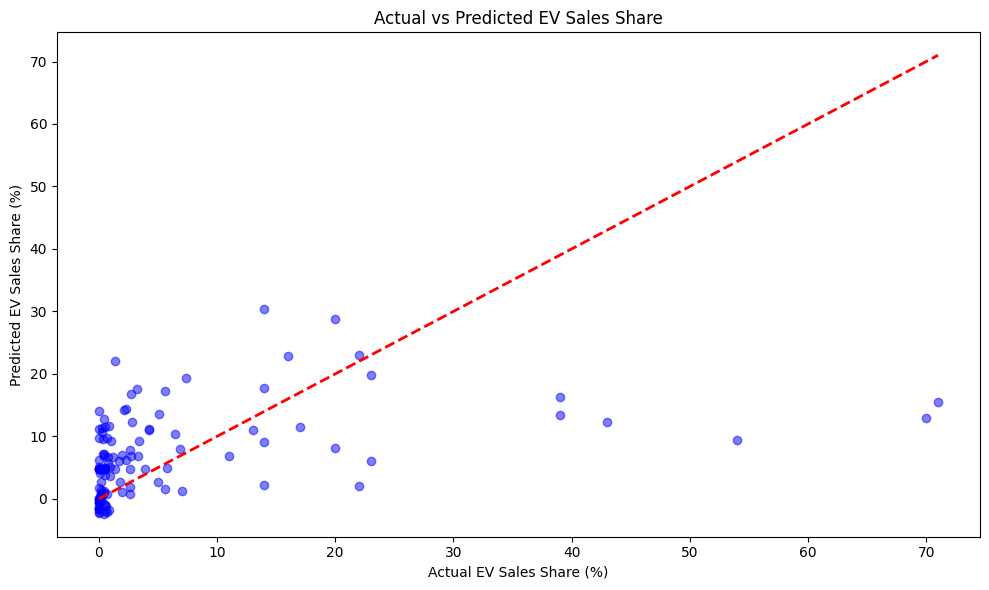

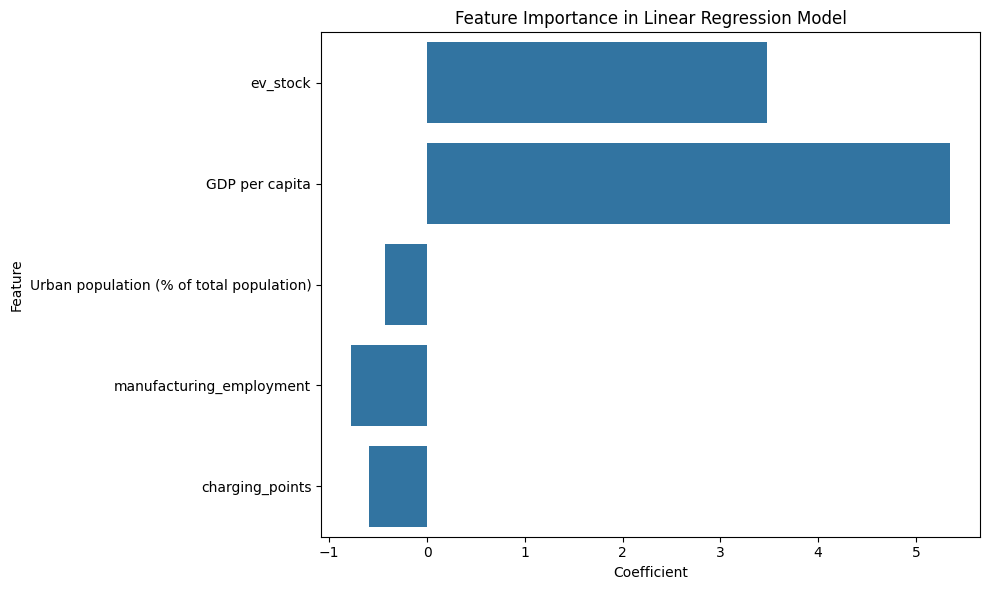

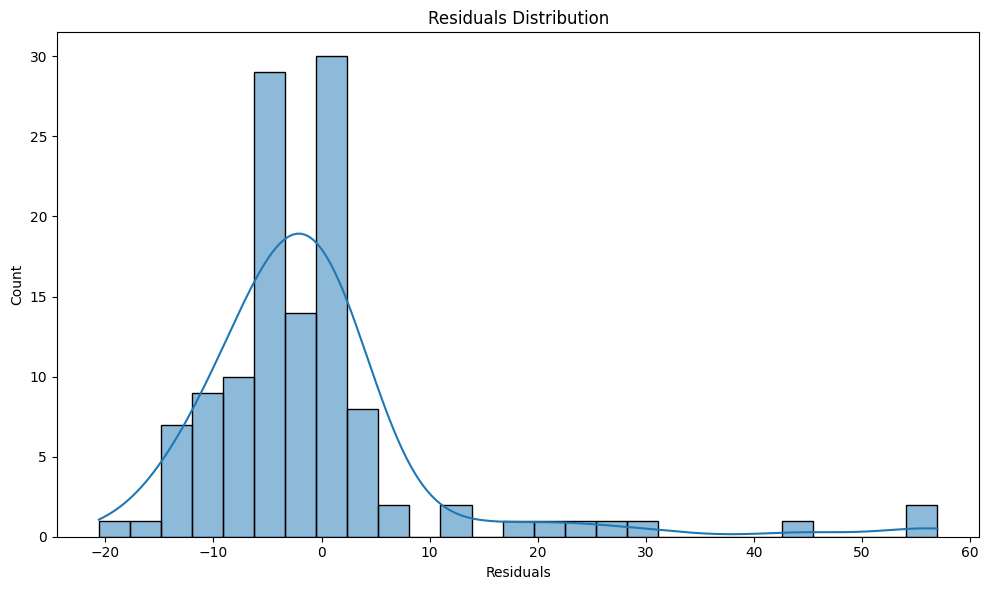

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Function to validate and load CSV
def load_csv(file_path, expected_columns=None, rename_map=None, skiprows=None, skipfooter=0):
    try:
        df = pd.read_csv(file_path, sep=',', encoding='utf-8', skiprows=skiprows, skipfooter=skipfooter, engine='python')
        print(f"Loaded {file_path} Shape:", df.shape)
        print(f"Columns:", df.columns.tolist())
        if expected_columns:
            missing_cols = [col for col in expected_columns if col not in df.columns]
            if missing_cols:
                print(f"Warning: Missing expected columns {missing_cols} in {file_path}")
        if rename_map:
            df = df.rename(columns=rename_map)
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        exit(1)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

# Expanded region mapping
region_map = {
    'United States': 'USA',
    'Turkiye': 'Turkey',
    'South Korea': 'Korea',
    'Korea, Republic of': 'Korea',
    'Russian Federation': 'Russia',
    'United Kingdom': 'UK',
    'United Arab Emirates': 'UAE',
    'Czech Republic': 'Czechia',
    'Iran, Islamic Republic of': 'Iran',
    'Hong Kong, China': 'Hong Kong',
    'Taiwan, Province of China': 'Taiwan',
    'Syrian Arab Republic': 'Syria',
    'Viet Nam': 'Vietnam',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Congo, Democratic Republic of the': 'Democratic Republic of Congo',
    'Moldova, Republic of': 'Moldova',
    'Tanzania, United Republic of': 'Tanzania',
    'Lao People’s Democratic Republic': 'Laos',
    'Palestine, State of': 'Palestine',
    'Brunei Darussalam': 'Brunei',
    'Macao, China': 'Macao',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Timor-Leste': 'Timor-Leste',
    'Côte d’Ivoire': 'Cote d’Ivoire',
    'Cabo Verde': 'Cape Verde',
    'Eswatini': 'Eswatini',
    'Micronesia (Federated States of)': 'Micronesia',
    'North Macedonia': 'North Macedonia',
    'Somalia': 'Somalia'
}

# IEA regions (assumed based on dataset)
iea_regions = [
    'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 'Denmark', 'Finland',
    'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands',
    'New Zealand', 'Norway', 'Poland', 'Portugal', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
    'Thailand', 'Turkey', 'UK', 'USA', 'World', 'EU27', 'Europe', 'Other Europe', 'Rest of World'
]

# Load datasets
# IEA dataset
iea_data = load_csv(
    '/content/IEA Global EV Data 2024 2025-05-14 11_53_51.csv',
    expected_columns=['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit', 'value']
)

# World Bank GDP per capita
wb_gdp_data = load_csv(
    '/content/WorldBankIndicator_GDPperCapital.csv',
    skiprows=4,
    skipfooter=5  # Skip footer notes if present
)
if wb_gdp_data is not None:
    # Select relevant columns
    year_columns = [col for col in wb_gdp_data.columns if col.isdigit()]
    wb_gdp_data = wb_gdp_data[['Country Name'] + year_columns]
    # Reshape from wide to long format
    wb_gdp_data = wb_gdp_data.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='year',
        value_name='GDP per capita'
    )
    wb_gdp_data = wb_gdp_data.rename(columns={'Country Name': 'region'})
    wb_gdp_data['year'] = wb_gdp_data['year'].astype(int)
    wb_gdp_data['region'] = wb_gdp_data['region'].replace(region_map)
    wb_gdp_data = wb_gdp_data[['region', 'year', 'GDP per capita']]
    print("WB GDP Reshaped Shape:", wb_gdp_data.shape)
    print("WB GDP Head:\n", wb_gdp_data.head())
    print("WB GDP Missing Values:\n", wb_gdp_data.isna().sum())
else:
    print("Failed to load GDP data. Exiting.")
    exit(1)

# World Bank Urban Population
wb_urban_data = load_csv(
    '/content/WorldBankIndicator_urbanpopulation.csv',
    skiprows=4,
    skipfooter=5
)
if wb_urban_data is not None:
    year_columns = [col for col in wb_urban_data.columns if col.isdigit()]
    wb_urban_data = wb_urban_data[['Country Name'] + year_columns]
    wb_urban_data = wb_urban_data.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='year',
        value_name='Urban population (% of total population)'
    )
    wb_urban_data = wb_urban_data.rename(columns={'Country Name': 'region'})
    wb_urban_data['year'] = wb_urban_data['year'].astype(int)
    wb_urban_data['region'] = wb_urban_data['region'].replace(region_map)
    wb_urban_data = wb_urban_data[['region', 'year', 'Urban population (% of total population)']]
    print("WB Urban Reshaped Shape:", wb_urban_data.shape)
    print("WB Urban Head:\n", wb_urban_data.head())
    print("WB Urban Missing Values:\n", wb_urban_data.isna().sum())
else:
    print("Failed to load Urban Population data. Exiting.")
    exit(1)

# SDG Manufacturing Employment
sdg_manuf_data = load_csv(
    '/content/SDG indicator 9.2.2 - Manufacturing employment as a proportion of total employment (%) 2025-05-13 13_24_54.csv',
    expected_columns=['ref_area.label', 'time', 'obs_value'],
    rename_map={'ref_area.label': 'region', 'time': 'year', 'obs_value': 'manufacturing_employment'}
)
# Filter out regional aggregates
non_country_regions = [
    'World excluding BRICS', 'G7', 'MENA', 'Arab League', 'CARICOM', 'European Union 27',
    'Arab States: Low income', 'APEC', 'World excluding India and China',
    'World: Lower-middle income excluding India', 'World: Upper-middle income excluding China'
]
sdg_manuf_data = sdg_manuf_data[~sdg_manuf_data['region'].isin(non_country_regions)]
sdg_manuf_data['region'] = sdg_manuf_data['region'].replace(region_map)
# Filter SDG regions to match IEA or mapped regions
sdg_manuf_data = sdg_manuf_data[sdg_manuf_data['region'].isin(iea_regions) | sdg_manuf_data['region'].isin(region_map.values())]
sdg_manuf_data = sdg_manuf_data[['region', 'year', 'manufacturing_employment']]
print("SDG Manuf Data Shape:", sdg_manuf_data.shape)
print("SDG Manuf Head:\n", sdg_manuf_data.head())
print("SDG Manuf Missing Values:\n", sdg_manuf_data.isna().sum())

# Print unique regions for debugging
print("IEA Regions:", sorted(iea_data['region'].unique()))
print("SDG Regions:", sorted(sdg_manuf_data['region'].unique()))
print("Common Regions:", sorted(set(iea_data['region']).intersection(sdg_manuf_data['region'])))

# Process IEA Data
iea_historical = iea_data[iea_data['category'] == 'Historical']
print("IEA Historical Shape:", iea_historical.shape)

# EV Sales Share
ev_sales = iea_historical[
    (iea_historical['parameter'] == 'EV sales share') &
    (iea_historical['mode'] == 'Cars')
][['region', 'year', 'powertrain', 'value']].rename(columns={'value': 'ev_sales_share'})
print("EV Sales Shape:", ev_sales.shape)
print("EV Sales Head:\n", ev_sales.head())

# EV Stock
ev_stock = iea_historical[
    (iea_historical['parameter'] == 'EV stock') &
    (iea_historical['mode'] == 'Cars') &
    (iea_historical['powertrain'].isin(['BEV', 'PHEV', 'FCEV']))
]
ev_stock_pivot = ev_stock.pivot_table(
    index=['region', 'year'],
    values='value',
    aggfunc='sum'
).reset_index().rename(columns={'value': 'ev_stock'})
print("EV Stock Pivot Shape:", ev_stock_pivot.shape)
print("EV Stock Pivot Head:\n", ev_stock_pivot.head())

# Charging Points
charging_points = iea_historical[
    (iea_historical['parameter'] == 'EV charging points') &
    (iea_historical['powertrain'].isin(['Publicly available fast', 'Publicly available slow']))
]
charging_points_pivot = charging_points.pivot_table(
    index=['region', 'year'],
    values='value',
    aggfunc='sum'
).reset_index().rename(columns={'value': 'charging_points'})
print("Charging Points Pivot Shape:", charging_points_pivot.shape)
print("Charging Points Pivot Head:\n", charging_points_pivot.head())

# Merge IEA Data
iea_processed = ev_sales.merge(
    ev_stock_pivot,
    on=['region', 'year'],
    how='left'
).merge(
    charging_points_pivot,
    on=['region', 'year'],
    how='left'
)
print("IEA Processed Shape:", iea_processed.shape)
print("IEA Processed Head:\n", iea_processed.head())
print("Missing values in IEA Processed:\n", iea_processed.isna().sum())

# Merge with World Bank and SDG Data
data = iea_processed.merge(
    wb_gdp_data[['region', 'year', 'GDP per capita']],
    on=['region', 'year'],
    how='left'
).merge(
    wb_urban_data[['region', 'year', 'Urban population (% of total population)']],
    on=['region', 'year'],
    how='left'
).merge(
    sdg_manuf_data[['region', 'year', 'manufacturing_employment']],
    on=['region', 'year'],
    how='left'
)
print("Merged Data Shape:", data.shape)
print("Merged Data Columns:", data.columns.tolist())
print("Merged Data Head:\n", data.head())
print("Missing values in Merged Data:\n", data.isna().sum())

# Prepare data for modeling
data = data.dropna(subset=['ev_sales_share'])
print("Data Shape after dropping NaN target:", data.shape)

# Define features
available_features = ['ev_stock', 'GDP per capita', 'Urban population (% of total population)', 'manufacturing_employment']
if 'charging_points' in data.columns and data['charging_points'].notna().any():
    available_features.append('charging_points')
print("Available Features:", available_features)

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
data[available_features] = num_imputer.fit_transform(data[available_features])
print("Missing values after imputation:\n", data[available_features].isna().sum())

# Select features and target
X = data[available_features]
y = data['ev_sales_share']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Multiple Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluate
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Coefficient': model.coef_
})
print("\nFeature Importance:\n", feature_importance)

# Plots
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual EV Sales Share (%)')
plt.ylabel('Predicted EV Sales Share (%)')
plt.title('Actual vs Predicted EV Sales Share')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance in Linear Regression Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_test
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()